# Predictive Modelling


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
import numpy as np

In [2]:
df = pd.read_csv('final.csv')

#### What metric is most important in this scenario?

In cases such as credit default we can make the following interpretations from our results:

THESE ARE OUR DESIRABLE PREDICTIONS:
* True Positive: Correctly identifying those who will default on credit
* True Negative: Correctly identifying those who will not default on credit

UNDESIRABLE PREDICTIONS:
* False Positive: Incorrectly identifying an individual who will not default, as a defaulter
* False Negative: Unable to identify those who will actually default

In my opinion, false negatives (type 2 error) are the most undesirable outcome in this scenario. The cost of classifying default as not default is very high

For this reason I believe that sensitivity or the recall rate is the most important evaluation metric in this scenario

Recall = TP/TP+FN



Will explore many machine learning techniques including:
* Logistic Regression
* KNN
* Decision Trees - Random Forest
* SVM
* PCA

etc

## LOGISTIC REGRESSION

Logistic regression allows us to predict probabilities. More specifically, the probability that an observation is of a certain class using a binary approach

In [3]:
X = np.array(df.drop(columns = 'default_next_month'))
y = np.array(df['default_next_month']).reshape(-1, 1)

In [4]:
X.shape

(30000, 38)

In [5]:
from sklearn.preprocessing import StandardScaler
# instatiate standard scaler
ss = StandardScaler()
# and standardize the data
X = ss.fit_transform(X)


# we found in our EDA that there is a class imbalance in the dataset, where just over 22% saw defaults
# in order to correct for this class imbalance, we have two options:
# 1. 'balanced' in class weight argument when instantiating logistic regression
# 2. Use SMOTE (synthetic minority oversampling technique
# however, firstly I will create a baseline model without either technique to gauge the results 


#### Logistic Regression: Without SMOTE or Class Balance

In [6]:
# splitting the data into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123, shuffle = True)

In [7]:
#import logistic regression model and fit to the model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver = 'lbfgs', max_iter=1000)

In [8]:
# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for the training dataset
train_pred = clf.predict(X_train)

# prediction for the testing dataset
test_pred = clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score,  recall_score, f1_score, precision_score
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred, y_test))
print('Recall score for Training Dataset = ', recall_score(train_pred, y_train))
print('Recall score for Testing Dataset = ', recall_score(test_pred, y_test))
print('F1 score for Training Dataset = ', f1_score(train_pred, y_train))
print('F1 score for Testing Dataset = ', f1_score(test_pred, y_test))
print('Precision score for Training Dataset = ', precision_score(train_pred, y_train))
print('Precision score for Testing Dataset = ', precision_score(test_pred, y_test))



Accuracy score for Training Dataset =  0.8192083333333333
Accuracy score for Testing Dataset =  0.8221666666666667
Recall score for Training Dataset =  0.6964780371982588
Recall score for Testing Dataset =  0.6825885978428351
F1 score for Training Dataset =  0.447894134113755
F1 score for Testing Dataset =  0.45366103430619553
Precision score for Training Dataset =  0.3300825206301575
Precision score for Testing Dataset =  0.3397239263803681


In [10]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train.ravel(), train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))
# A decent amount of true positives, and true negatives, but also an alarming amount of false negatives. 
# 3572/5332 defaulters have been predicted as not default 
# Probably because of class imbalance our modelling has not been able to identify those who are likely to default
# False positive rate is quite low however, with 767/18668 incorrectly identified. (but we want to keep this 
# as low as possible)

Confusion Matrix - Training Dataset
Predicted      0     1    All
True                         
0          17901   767  18668
1           3572  1760   5332
All        21473  2527  24000


#### Repeating the above with class balance in the instantiation of Logistic Regression

In [11]:
clf1 = LogisticRegression(solver = 'lbfgs', max_iter = 1000, class_weight= 'balanced')

# fit the model
clf1.fit(X_train, y_train.ravel())

# prediction for the training dataset
train_pred = clf1.predict(X_train)

# prediction for the testing dataset
test_pred = clf1.predict(X_test)

print('Accuracy score for Training Dataset = ', accuracy_score(train_pred, y_train))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred, y_test))
print('Recall score for Training Dataset = ', recall_score(train_pred, y_train))
print('Recall score for Testing Dataset = ', recall_score(test_pred, y_test))
print('F1 score for Training Dataset = ', f1_score(train_pred, y_train))
print('F1 score for Testing Dataset = ', f1_score(test_pred, y_test))
print('Precision score for Training Dataset = ', precision_score(train_pred, y_train))
print('Precision score for Testing Dataset = ', precision_score(test_pred, y_test))



print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train.ravel(), train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Accuracy score for Training Dataset =  0.78
Accuracy score for Testing Dataset =  0.7818333333333334
Recall score for Training Dataset =  0.5045233124565066
Recall score for Testing Dataset =  0.4982770503101309
F1 score for Training Dataset =  0.523465703971119
F1 score for Testing Dataset =  0.5248638838475499
Precision score for Training Dataset =  0.5438859714928732
Precision score for Testing Dataset =  0.5544478527607362
Confusion Matrix - Training Dataset
Predicted      0     1    All
True                         
0          15820  2848  18668
1           2432  2900   5332
All        18252  5748  24000


In [12]:
# There is a lower accuracy score for both training and testing data set
# recall is also falling here which is not good
# seems to be a trade off with TPR and FPR here. TPR rising, but FPR decreasing
# precision is doing better, which means f1 does better because it's a harmonised mean between precision and recall

#### Using SMOTE

Under the hood, the SMOTE algorithm works in 4 simple steps:

* Choose a minority class input vector
* Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
* Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
* Repeat the steps until data is balanced

In [13]:
# importing SMOTE from imblearn
from imblearn.over_sampling import SMOTE

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [14]:
smote = SMOTE(random_state=123)

# creating SMOTE'D data
X_train_new, y_train_new = smote.fit_sample(X_train, y_train.ravel())

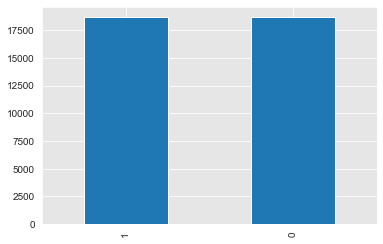

In [15]:
# We can visualise the now balanced class
balanced = pd.Series(y_train_new)
balanced.value_counts().plot.bar();

In [16]:
# now fitting the model with new train data
clf2 = LogisticRegression(solver= 'lbfgs', max_iter=1000)

# fit the model
clf2.fit(X_train_new, y_train_new)

# predicting for training data
train_pred_smote = clf2.predict(X_train_new)

# predicting for testing data
test_pred_smote = clf2.predict(X_test)

In [17]:
# calculating accuracy scores
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_smote, y_train_new))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_smote, y_test))
print('Recall score for Training Dataset = ', recall_score(train_pred_smote, y_train_new))
print('Recall score for Testing Dataset = ', recall_score(test_pred_smote, y_test))
print('F1 score for Training Dataset = ', f1_score(train_pred_smote, y_train_new))
print('F1 score for Testing Dataset = ', f1_score(test_pred_smote, y_test))
print('Precision score for Training Dataset = ', precision_score(train_pred_smote, y_train_new))
print('Precision score for Testing Dataset = ', precision_score(test_pred_smote, y_test))

Accuracy score for Training Dataset =  0.6991643454038997
Accuracy score for Testing Dataset =  0.777
Recall score for Training Dataset =  0.7790872241405195
Recall score for Testing Dataset =  0.4885906040268456
F1 score for Training Dataset =  0.6488902782119413
F1 score for Testing Dataset =  0.5211166785969935
Precision score for Training Dataset =  0.5559781444182559
Precision score for Testing Dataset =  0.558282208588957


In [18]:
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train_new, train_pred_smote, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Training Dataset
Predicted      0      1    All
True                          
0          15725   2943  18668
1           8289  10379  18668
All        24014  13322  37336


In [19]:
print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test.ravel(), test_pred_smote, rownames = ['True'], colnames = ['Predicted'], margins = True))

Confusion Matrix - Testing Dataset
Predicted     0     1   All
True                       
0          3934   762  4696
1           576   728  1304
All        4510  1490  6000


In [20]:
# seems to be a large disparity in training versus test set here for recall (which is what we want)

#### Further optimisation using GridSearch

In [147]:

# importing
from sklearn.model_selection import GridSearchCV

# instantiating
clf3 = LogisticRegression(solver = 'lbfgs', max_iter=1000)

# creating regularization penalty and hyperparameter space
# penalties = ['l1', 'l2']
C = np.logspace(0,4,10)
hyper_params = dict(C = C) #penalty = penalties)

# getting an optimum model with gridsearch
opt_model = GridSearchCV(clf3, hyper_params, cv = 5, verbose = 0, scoring = 'f1')
# fitting
opt_model.fit(X_train_new, y_train_new)
opt_model.best_params_



{'C': 1.0}

In [22]:
best_model = opt_model.best_estimator_
# now getting evaluation metrics with our optimised model
train_pred = best_model.predict(X_train_new)

# prediction for the testing dataset
test_pred = best_model.predict(X_test)

# importing
from sklearn.metrics import roc_curve, auc, roc_auc_score
acc = accuracy_score(y_test, test_pred)
print('Accuracy is :{0}'.format(acc))
print('Recall is:{0}'.format(recall_score(y_test, test_pred)))

y_score = opt_model.decision_function(X_test)
# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test.ravel(), test_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is :0.777
Recall is:0.558282208588957

AUC is :0.76

Confusion Matrix
----------------


Predicted     0     1   All
True                       
0          3934   762  4696
1           576   728  1304
All        4510  1490  6000

AUC: 0.761958356413499


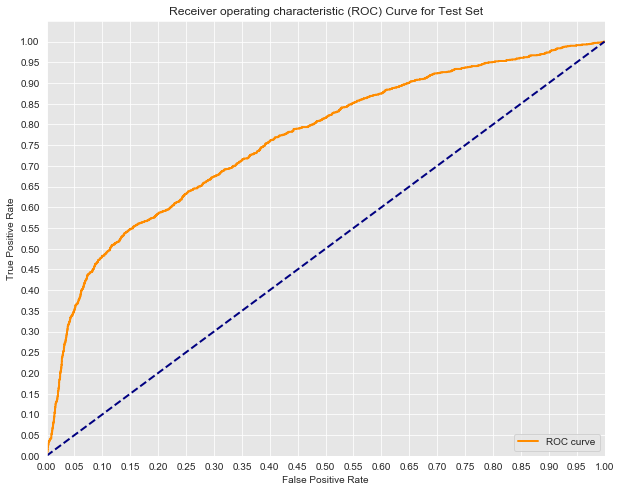

In [23]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

In [24]:
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.6991643454038997
Accuracy score for Testing Dataset =  0.777
Recall score for Training Dataset =  0.5559781444182559
Recall score for Testing Dataset =  0.558282208588957
F1 score for Training Dataset =  0.6488902782119413
F1 score for Testing Dataset =  0.5211166785969935
Precision score for Training Dataset =  0.7790872241405195
Precision score for Testing Dataset =  0.4885906040268456


In [25]:
# recall seems to be performing ok, and because false negatives are bad, this is more desirable

## Support Vector Machines

SVM classifier tries to fit the wideset possible 'street' between classes
* This is known as *large margin classification* 
* Hard margin classification only works if data is linearly separable, with it also being highly sensitive to outliers 
* So instead use soft margin classification

We have several hyperparameters:
* C - high C means lower margin

### Linear SVM

In [26]:
# importing libraries
from sklearn.svm import LinearSVC
# importing pipeline to speed up process
from sklearn.pipeline import Pipeline

# instantiating the model
lin_svm = Pipeline([("scaler", StandardScaler()), ("linear_svc", LinearSVC(C = 1, max_iter = 100000, loss = "hinge"))])

# fitting the model & keeping the SMOTE train sample
lin_svm.fit(X_train_new, y_train_new)



In [37]:
# getting predictions
train_pred = lin_svm.predict(X_train_new)
test_pred = lin_svm.predict(X_test)

# getting scores
y_score = opt_model.decision_function(X_test)
# Plotting roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)

In [38]:
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.6886918791514892
Accuracy score for Testing Dataset =  0.7823333333333333
Recall score for Training Dataset =  0.5207306620955646
Recall score for Testing Dataset =  0.5276073619631901
F1 score for Training Dataset =  0.6258490262353131
F1 score for Testing Dataset =  0.5130499627143923
Precision score for Training Dataset =  0.7841413245139953
Precision score for Testing Dataset =  0.49927431059506533


In [27]:
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test.ravel(), test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


AUC is :0.76

Confusion Matrix
----------------


Predicted     0     1   All
True                       
0          4006   690  4696
1           616   688  1304
All        4622  1378  6000

AUC: 0.761958356413499


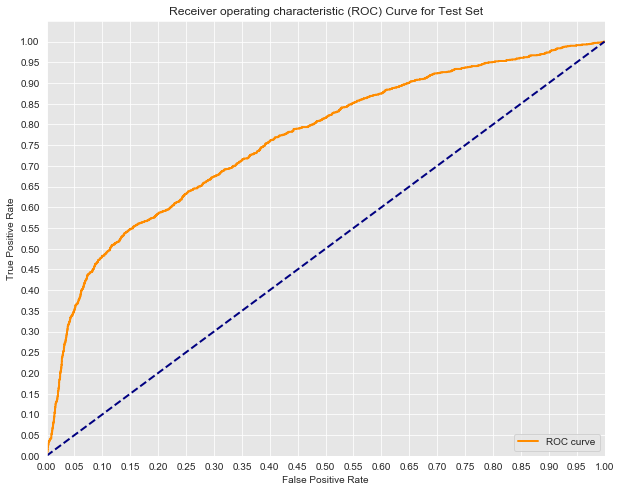

In [28]:
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

### Nonlinear SVM Classification
#### Polynomial Kernel

In [45]:
# importing library
from sklearn.svm import SVC

# Instantiation model with probabilities set as True
# poly_kern_clf = Pipeline([("svm_clf", SVC(kernel = "poly", degree = 2, coef0 = 1, C = 5))])

# Setting parameter grid
# param_grid = {'C': [10**i for i in range(-3, 5)], 'gamma': [10**i for i in range(-7,3)], 'kernel': ['poly']}

# Finding the optimal model
# opt_model = GridSearchCV(poly_kern, param_grid, cv = 5, scoring = 'f1')

# fitting the model
# poly_kern_clf.fit(X_train_new, y_train_new)
# best_model = opt_model.best_estimator_

# retrieving the best parameters
# opt_model.best_params_
poly_kern = SVC(max_iter=20, probability=True, kernel = 'poly', degree = 2)

param_grid = {'C': [10**i for i in range(-3,5)], 'gamma': [10**i for i in range(-7,3)]}

opt_model = GridSearchCV(poly_kern, param_grid, cv = 3, scoring = 'f1'
                    , n_jobs = -1, return_train_score=True)

opt_model.fit(X_train_new, y_train_new)
best_model = opt_model.best_estimator_

opt_model.best_params_

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 0.001, 'gamma': 100}

AUC: 0.5224244494727271


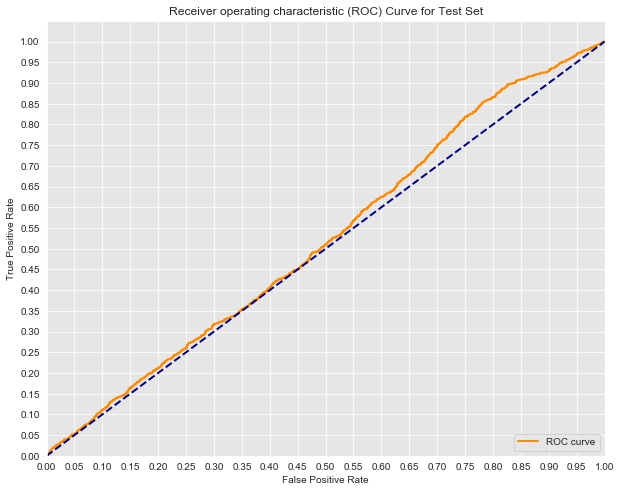

In [46]:
y_score = opt_model.decision_function(X_test)
# Plotting roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

In [47]:
# getting predictions
train_pred = best_model.predict(X_train_new)
test_pred = best_model.predict(X_test)

print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.500883865438183
Accuracy score for Testing Dataset =  0.2195
Recall score for Training Dataset =  0.9975894578958646
Recall score for Testing Dataset =  0.9984662576687117
F1 score for Training Dataset =  0.666523505305918
F1 score for Testing Dataset =  0.3573487031700288
Precision score for Training Dataset =  0.5004433934377771
Precision score for Testing Dataset =  0.21761658031088082


In [48]:
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test.ravel(), test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted   0     1   All
True                     
0          15  4681  4696
1           2  1302  1304
All        17  5983  6000

In [49]:
# Taking too long to optimise with this classifier given the computational power i have
# will move on

## Decision Tree Classifier

In [100]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state = 123)

param_grid = {'max_depth': range(1, 8+1), 'min_samples_leaf': [5, 10, 15]}

opt_model = GridSearchCV(tree_clf, param_grid, cv = 3, scoring = 'f1')
opt_model.fit(X_train_new, y_train_new)
best_model = opt_model.best_estimator_

opt_model.best_params_

{'max_depth': 8, 'min_samples_leaf': 5}

In [101]:
pd.DataFrame(opt_model.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.032140      0.002783         0.006096        0.002620   
1        0.027511      0.003510         0.005436        0.002100   
2        0.024869      0.001128         0.003824        0.000602   
3        0.037632      0.003451         0.003478        0.000220   
4        0.036692      0.002179         0.003407        0.000158   
5        0.039054      0.002228         0.003477        0.000121   
6        0.059700      0.001050         0.003984        0.000257   
7        0.051491      0.001608         0.003447        0.000150   
8        0.056505      0.000926         0.004397        0.000378   
9        0.072952      0.008706         0.003557        0.000174   
10       0.067209      0.002390         0.003639        0.000155   
11       0.075304      0.006910         0.004530        0.000806   
12       0.079911      0.003677         0.003680        0.000117   
13       0.087471      0.003612         0.003948        0.000292   
14       0.091873      0.012078         0.003765        0.000372   
15       0.096090      0.002087         0.004094        0.000201   
16       0.104348      0.009441         0.004403        0.000551   
17       0.094495      0.003422         0.003639        0.000120   
18       0.116617      0.001981         0.004341        0.000289   
19       0.127432      0.023559         0.004041        0.000567   
20       0.124591      0.012387         0.004303        0.000249   
21       0.128150      0.009020         0.003940        0.000152   
22       0.132160      0.003077         0.003981        0.000221   
23       0.135162      0.006883         0.004029        0.000161   

   param_max_depth param_min_samples_leaf  \
0                1                      5   
1                1                     10   
2                1                     15   
3                2                      5   
4                2                     10   
5                2                     15   
6                3                      5   
7                3                     10   
8                3                     15   
9                4                      5   
10               4                     10   
11               4                     15   
12               5                      5   
13               5                     10   
14               5                     15   
15               6                      5   
16               6                     10   
17               6                     15   
18               7                      5   
19               7                     10   
20               7                     15   
21               8                      5   
22               8                     10   
23               8                     15   

                                      params  split0_test_score  \
0    {'max_depth': 1, 'min_samples_leaf': 5}           0.419635   
1   {'max_depth': 1, 'min_samples_leaf': 10}           0.419635   
2   {'max_depth': 1, 'min_samples_leaf': 15}           0.419635   
3    {'max_depth': 2, 'min_samples_leaf': 5}           0.554816   
4   {'max_depth': 2, 'min_samples_leaf': 10}           0.554816   
5   {'max_depth': 2, 'min_samples_leaf': 15}           0.554816   
6    {'max_depth': 3, 'min_samples_leaf': 5}           0.549261   
7   {'max_depth': 3, 'min_samples_leaf': 10}           0.549261   
8   {'max_depth': 3, 'min_samples_leaf': 15}           0.549261   
9    {'max_depth': 4, 'min_samples_leaf': 5}           0.567992   
10  {'max_depth': 4, 'min_samples_leaf': 10}           0.568082   
11  {'max_depth': 4, 'min_samples_leaf': 15}           0.572589   
12   {'max_depth': 5, 'min_samples_leaf': 5}           0.595355   
13  {'max_depth': 5, 'min_samples_leaf': 10}           0.592958   
14  {'max_depth': 5, 'min_samples_leaf': 15}           0.598116   
15   {'max_depth': 6, 'min_samples_leaf': 5}           0.581495   
16  {'max_depth': 6, 'min_samples_leaf

In [102]:
train_pred = best_model.predict(X_train_new)
test_pred = best_model.predict(X_test)

print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.7251178487250911
Accuracy score for Testing Dataset =  0.772
Recall score for Training Dataset =  0.6050996357403042
Recall score for Testing Dataset =  0.5567484662576687
F1 score for Training Dataset =  0.687627453964389
F1 score for Testing Dataset =  0.5148936170212767
Precision score for Training Dataset =  0.7962218932825826
Precision score for Testing Dataset =  0.4788918205804749


AUC: 0.7387467861957964


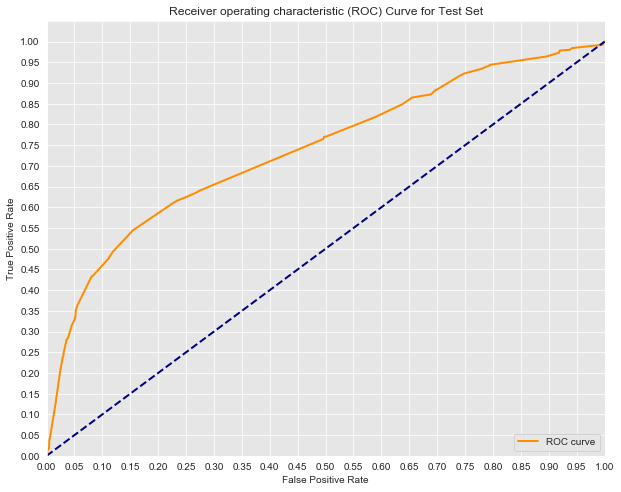

In [103]:
proba = opt_model.predict_proba(X_test)[:,1]
# Plotting roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, proba)

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

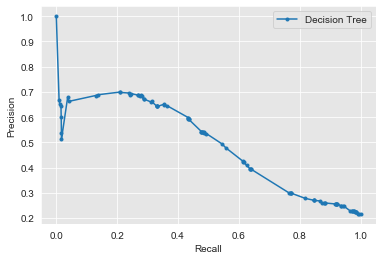

In [105]:
precision, recall, _ = precision_recall_curve(y_test, proba)
plt.plot(recall, precision, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

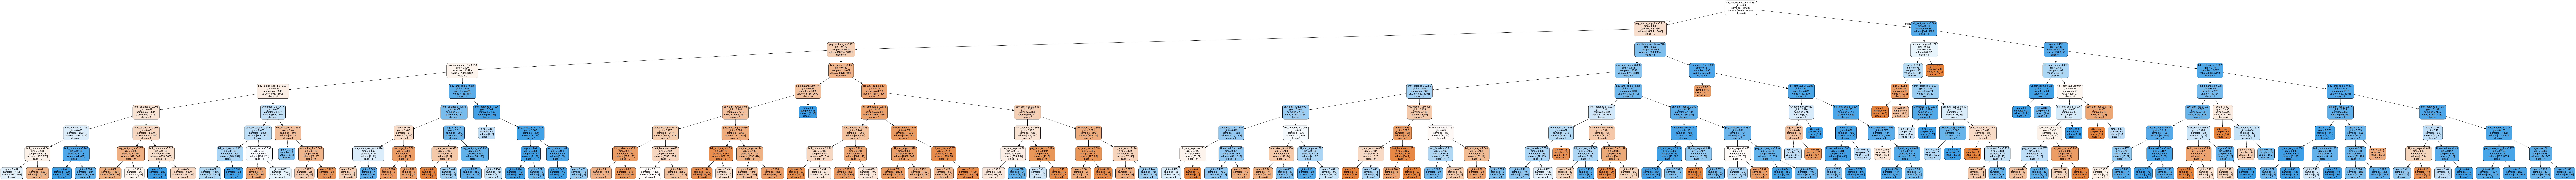

In [79]:
from sklearn.tree import export_graphviz
from IPython.display import Image  
from pydotplus import graph_from_dot_data

dot_data = export_graphviz(best_model, out_file=None, 
                           feature_names=df.drop(columns = 'default_next_month').columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())
# nice graph to show it all :) 

## Random Forests Classifiers

A Random Forest is an ensemble of Decision Trees, which are generally trained via bagging

In [71]:
# importing the library
from sklearn.ensemble import RandomForestClassifier

# instatiating the model, with 500 trees, a maximum of 16 nodes and using all available CPU cores
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state = 123)

# fit the model
rnd_clf.fit(X_train_new, y_train_new)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [72]:
# getting predictions
train_pred = rnd_clf.predict(X_train_new)
test_pred = rnd_clf.predict(X_test)

# scores
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.7061281337047354
Accuracy score for Testing Dataset =  0.7826666666666666
Recall score for Training Dataset =  0.5572101992714806
Recall score for Testing Dataset =  0.549079754601227
F1 score for Training Dataset =  0.6547079556898288
F1 score for Testing Dataset =  0.5233918128654971
Precision score for Training Dataset =  0.793561184009765
Precision score for Testing Dataset =  0.5


In [73]:
print('\nConfusion Matrix Train')
print('----------------')
display(pd.crosstab(y_train_new.ravel(), train_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print('\nConfusion Matrix Test')
print('----------------')
pd.crosstab(y_test.ravel(), test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix Train
----------------


Predicted      0      1    All
True                          
0          15962   2706  18668
1           8266  10402  18668
All        24228  13108  37336


Confusion Matrix Test
----------------


Predicted     0     1   All
True                       
0          3980   716  4696
1           588   716  1304
All        4568  1432  6000

AUC: 0.7679060171298376


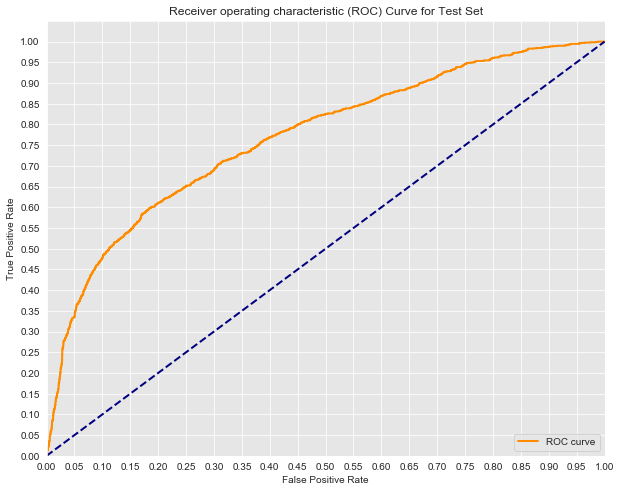

In [98]:
proba = rnd_clf.predict_proba(X_test)[:,1]
# Plotting roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, proba)

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

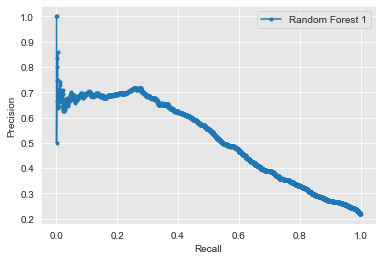

In [99]:
precision, recall, _ = precision_recall_curve(y_test, proba)
plt.plot(recall, precision, marker='.', label='Random Forest 1')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Without GridSearch optimisation, we are able to obtain a better AUC, and other evaluation metrics with Random Forest

### Random Forest Classification with GridSearchCV

In [84]:
rnd_clf1 = RandomForestClassifier(n_jobs = -1, random_state = 123)

param_grid = {'n_estimators': [200,300,400,500,600,700,800,900,1000], 'max_leaf_nodes': [5, 10, 15, 20 ,25, 30]}

opt_model = GridSearchCV(rnd_clf1, param_grid, cv = 3, scoring = 'f1')
opt_model.fit(X_train_new, y_train_new)
best_model = opt_model.best_estimator_

opt_model.best_params_

{'max_leaf_nodes': 30, 'n_estimators': 200}

#### Sanity Check

In [85]:
pd.DataFrame(opt_model.cv_results_)
# seems like 30 nodes and 200 trees is the most optimal in terms of f1 score

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.536963      0.925927         0.111696        0.002505   
1        1.317462      0.032320         0.110046        0.001199   
2        1.709732      0.020692         0.211665        0.003284   
3        2.139206      0.036594         0.212014        0.002658   
4        2.577311      0.032763         0.245374        0.045402   
5        3.015739      0.069928         0.313187        0.004316   
6        3.459663      0.074443         0.311969        0.002567   
7        3.830335      0.096331         0.411434        0.001831   
8        4.267972      0.096328         0.414397        0.003804   
9        1.085944      0.008449         0.110877        0.001609   
10       1.620839      0.040205         0.179158        0.047226   
11       2.084503      0.049081         0.210764        0.001649   
12       2.633989      0.008017         0.209162        0.000862   
13       3.073845      0.051932         0.313337        0.001867   
14       3.597545      0.059528         0.311722        0.003378   
15       4.105546      0.063517         0.313213        0.000592   
16       4.614004      0.135021         0.410140        0.002419   
17       5.103174      0.054796         0.412891        0.002422   
18       1.166916      0.006062         0.110415        0.002125   
19       1.734801      0.045275         0.143547        0.046785   
20       2.292555      0.049597         0.208651        0.001389   
21       2.845499      0.062118         0.214189        0.001784   
22       3.418268      0.130863         0.311263        0.002316   
23       3.954641      0.074586         0.310120        0.000925   
24       4.626805      0.171151         0.311331        0.001436   
25       5.038966      0.125360         0.413622        0.001600   
26       5.559312      0.071835         0.409367        0.001267   
27       1.254542      0.020684         0.110296        0.001230   
28       1.887932      0.056761         0.176960        0.048345   
29       2.428595      0.041845         0.212253        0.001713   
30       3.072918      0.059386         0.212718        0.001217   
31       3.600977      0.100789         0.321415        0.001855   
32       4.189554      0.078454         0.317542        0.001692   
33       4.806703      0.100234         0.323275        0.002232   
34       5.354192      0.131302         0.424358        0.005314   
35       5.986015      0.138900         0.418645        0.002359   
36       1.307184      0.024167         0.113340        0.004179   
37       1.905513      0.051875         0.143575        0.050425   
38       2.554431      0.080738         0.219181        0.002067   
39       3.167804      0.075545         0.216753        0.003424   
40       3.825617      0.139603         0.252069        0.043829   
41       4.398886      0.160782         0.318011        0.003597   
42       5.020333      0.136491         0.319323        0.002456   
43       5.643263      0.136025         0.425128        0.004683   
44       6.215260      0.129770         0.426316        0.003205   
45       1.335153      0.026670         0.114942        0.002360   
46       1.963698      0.030579         0.150226        0.048518   
47       2.632543      0.056148         0.218256        0.000986   
48       3.991833      0.641585         0.282092        0.048495   
49       4.445403      0.539964         0.347409        0.047775   
50       4.536765      0.076532         0.312871        0.001824   
51       5.204194      0.114270         0.314383        0.002182   
52       5.823038      0.124823         0.414211        0.000404   
53       6.421456      0.154651         0.412684        0.001478   

   param_max_leaf_nodes param_n_estimators  \
0                     5                200   
1                     5                300   
2                     5                400   
3                     5                500   
4                     5          

In [107]:
best_model = RandomForestClassifier(n_jobs = -1, random_state =123, n_estimators=200, max_leaf_nodes=30)

best_model.fit(X_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [108]:
# getting predictions
train_pred = best_model.predict(X_train_new)
test_pred = best_model.predict(X_test)

# scores
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.7156363831154917
Accuracy score for Testing Dataset =  0.7836666666666666
Recall score for Training Dataset =  0.5769230769230769
Recall score for Testing Dataset =  0.5559815950920245
F1 score for Training Dataset =  0.6698386043474204
F1 score for Testing Dataset =  0.5276564774381367
Precision score for Training Dataset =  0.7984283490251316
Precision score for Testing Dataset =  0.5020775623268698


In [109]:
print('\nConfusion Matrix Train')
print('----------------')
display(pd.crosstab(y_train_new.ravel(), train_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print('\nConfusion Matrix Test')
print('----------------')
pd.crosstab(y_test.ravel(), test_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix Train
----------------


Predicted      0      1    All
True                          
0          15949   2719  18668
1           7898  10770  18668
All        23847  13489  37336


Confusion Matrix Test
----------------


Predicted     0     1   All
True                       
0          3977   719  4696
1           579   725  1304
All        4556  1444  6000

AUC: 0.7387467861957964


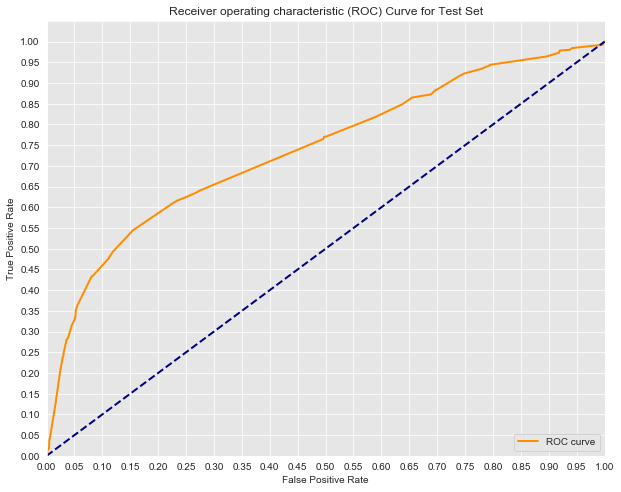

In [110]:
proba = opt_model.predict_proba(X_test)[:,1]
# Plotting roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, proba)

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(false_positive_rate, true_positive_rate)))
plt.show()

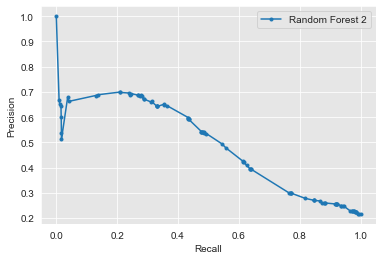

In [115]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, proba)
plt.plot(recall, precision, marker='.', label='Random Forest 2')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

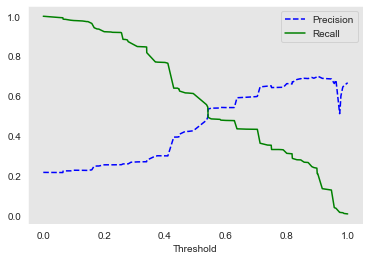

In [116]:
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label = 'Recall')
    plt.legend()
    plt.grid()
    plt.xlabel('Threshold')
    

plot_precision_recall_vs_threshold(precision, recall, thresholds)
plt.show()

## Voting Classifiers

A simple way of creating an even better classifier is to aggregate predictions of each classifier and predict the class that gets the most votes

In [118]:
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),('svc', svm_clf)], voting = 'hard')

voting_clf.fit(X_train_new, y_train_new)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_new, y_train_new)
    test_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, test_pred))

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 0.777


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier 0.7753333333333333


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.7823333333333333


/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.7875


In [119]:
train_pred = voting_clf.predict(X_train_new)
test_pred = voting_clf.predict(X_test)

# scores
print('Accuracy score for Training Dataset = ', accuracy_score(y_train_new, train_pred))
print('Accuracy score for Testing Dataset = ', accuracy_score(y_test, test_pred))
print('Recall score for Training Dataset = ', recall_score(y_train_new, train_pred))
print('Recall score for Testing Dataset = ', recall_score(y_test, test_pred))
print('F1 score for Training Dataset = ', f1_score(y_train_new, train_pred))
print('F1 score for Testing Dataset = ', f1_score(y_test, test_pred))
print('Precision score for Training Dataset = ', precision_score(y_train_new, train_pred))
print('Precision score for Testing Dataset = ', precision_score(y_test, test_pred))

Accuracy score for Training Dataset =  0.7222251982001285
Accuracy score for Testing Dataset =  0.7875
Recall score for Training Dataset =  0.5754767516605956
Recall score for Testing Dataset =  0.5398773006134969
F1 score for Training Dataset =  0.6744514549392598
F1 score for Testing Dataset =  0.5247856876630638
Precision score for Training Dataset =  0.8145424217150656
Precision score for Testing Dataset =  0.5105148658448151


In [ ]:
voting_clf.p

In [145]:
c = {'C':1}

In [146]:
c['C']

1